# ISYE-6740 - Final Project - Chest X Ray Images - Pneumonia

Data comes from the following Kaggle dataset: [Chst X-Rat Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810&sortBy=voteCount).

Good inspirational notebook can be found [here](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/notebook).

## Import Packages And Data

In [1]:
# packages

## general use
import numpy as np
import pandas as pd
import sys
import os
import cv2
import re

## plotting
import matplotlib.pyplot as plt
from plotnine import *

## modeling
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# data
file_directory = "C:\\Documents\\Education\\Georgia Tech\\Online Masters in Analytics\\2023-05 - Summer\\ISYE-6740 - Computational Data Analysis\\Final Project\\chest_xray\\chest_xray"
sys.path.append(file_directory)
# for dirname, _, filenames in os.walk(file_directory):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def read_xray_images(directory):
    """
    === DESCRIPTION ===
    
    
    === INPUTS ===
    
    
    === OUTPUT ===
    
    """
    data, true_labels, patient_ids = [], [], []
    for label in labels:
        path = '{}\\{}'.format(directory, label) # os.path.join(directory, label)
        for img in os.listdir(path):
            if img == '.DS_Store':
                continue
            try:
                # x
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_resize = cv2.resize(img_arr, (img_size, img_size)).flatten()
                
                # y
                if label == 'NORMAL':
                    class_id = 0
                elif 'bacteria' in img.lower():
                    class_id = 1
                elif 'virus' in img.lower():
                    class_id = 2
                else:
                    class_id = None      
                        
                # patient ID
                if label == 'NORMAL':
                    patient = re.search(r'IM-[0-9]{4}-[0-9]{4}', img).group()
                else:
                    patient = re.search(r'person[0-9]{1,4}', img).group()
                
                # output
                data.append(img_resize)
                true_labels.append(class_id)
                patient_ids.append(patient)
            except Exception as e:
                print(e)
    return np.stack(data), true_labels, patient_ids

In [4]:
# read data
X_train, y_train, p_train = read_xray_images('{}\\train'.format(file_directory))
X_test, y_test, p_test = read_xray_images('{}\\test'.format(file_directory))
# val = read_xray_images('{}\\val'.format(file_directory))

In [5]:
# show counts of classes by data grouping
def class_counts(data):
    """
    Count the occurences of each class within a data set
    """
    
    unique, counts = np.unique(data, return_counts = True)
    return dict(zip(unique, counts))

print('Train Classes:', class_counts(y_train))
print('Test Classes:', class_counts(y_test))

Train Classes: {0: 1341, 1: 2530, 2: 1345}
Test Classes: {0: 234, 1: 242, 2: 148}


## Pre Processing

In [6]:
# standardize X
X_train = X_train / 255
X_test = X_test / 255

In [7]:
X_train.shape

(5216, 22500)

In [8]:
np.array(y_train)

array([1, 2, 1, ..., 0, 0, 0])

## Exploratory Data Analysis

### PCA

In [9]:
X_train_pca = PCA(n_components = 6).fit_transform(X_train)
X_train_pca.shape

(5216, 6)

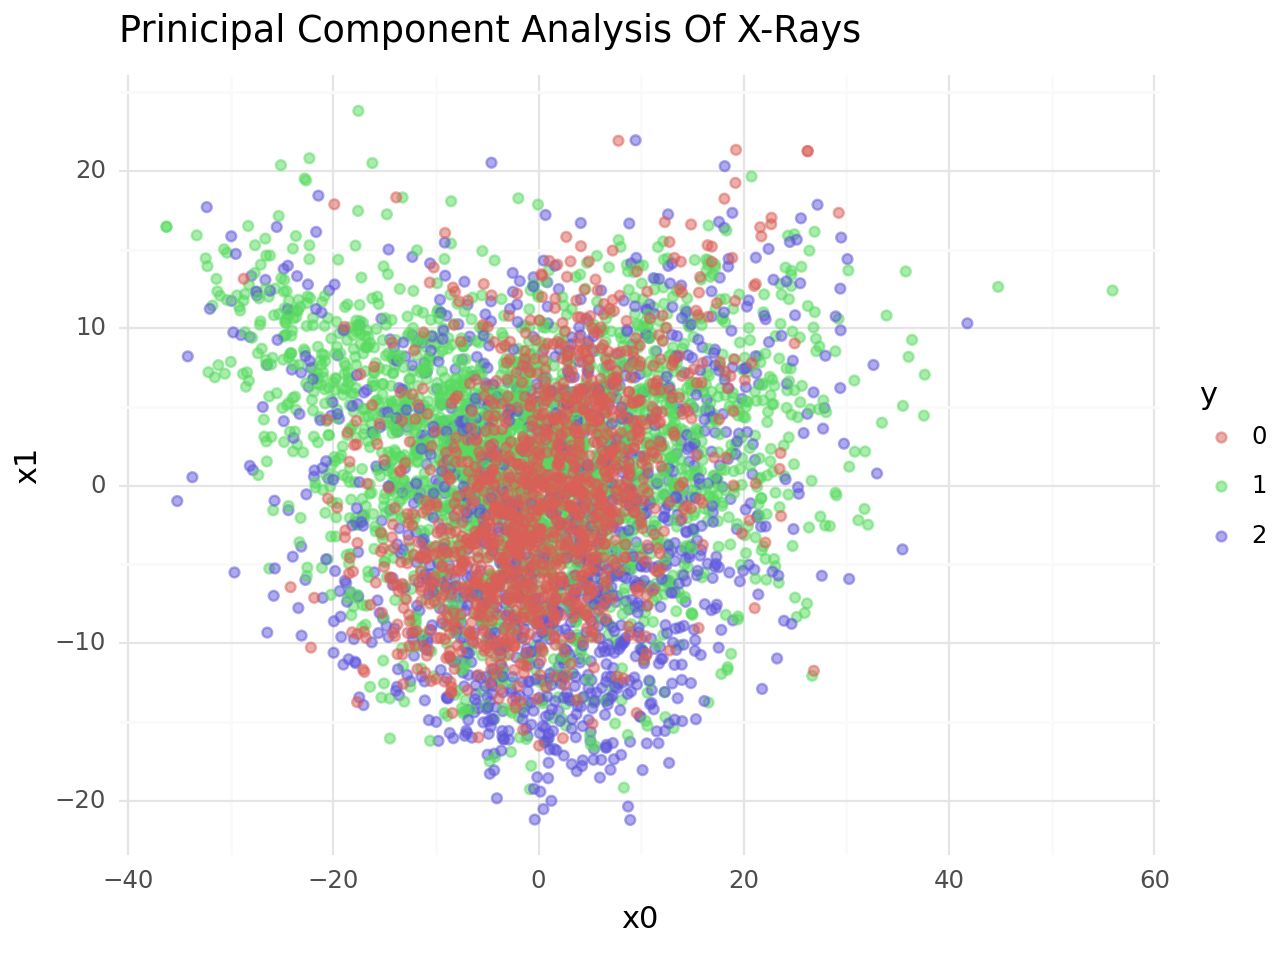

<Figure Size: (640 x 480)>

In [11]:
pca_df = pd.DataFrame({
    'y': [str(i) for i in y_train],
    'x0': X_train_pca[:, 0],
    'x1': X_train_pca[:, 1]
})

fig = (
    ggplot(pca_df, aes("x0", "x1")) + 
        geom_point(aes(color = "y"), alpha = 0.5) + 
        labs(
            title = 'Prinicipal Component Analysis Of X-Rays'
        ) +
        theme_minimal()
)

fig

## Model

### Useful Global Functions

In [12]:
def report_classification_performance_metrics(mod, mod_name, verbose = True):
    """
    Given a classification model `mod` with string value name `mod_name`,
    provide the classification report (which includes precision, recall,
    and F-1 score) as well as the confusion matrix.
    """
    pred = mod.predict(X_test)
    class_report = classification_report(y_test, pred)
    conf_mat = confusion_matrix(y_true = y_test, y_pred = pred)
    
    if verbose == True:
        print('===')
        print('=== {} ==='.format(mod_name))
        print('===\n')
        print('=== Classification Report ===\n')
        print(class_report)
        print('=== Confusion Matrix ===\n')
        print(conf_mat)
    else:
        return class_report, conf_mat

## KNN

In [13]:
# tune KNN
knn_neighbors, knn_scores = [], []
for i in range(3, 20, 1):
    mod = KNeighborsClassifier(n_neighbors = i + 1).fit(X_train, y_train)
    mod_score = mod.score(X_test, y_test)
    knn_neighbors.append(i + 1)
    knn_scores.append(mod_score)

best_neighbors = knn_neighbors[np.argmax(knn_scores)]
plt.figure(figsize = (8,3))
plt.scatter(knn_neighbors, knn_scores)
plt.title('Tuning KNN For X-Rays (Optimal K = {})'.format(best_neighbors));

In [14]:
# train KNN model
mod_knn = KNeighborsClassifier(n_neighbors=best_neighbors).fit(X_train, y_train)
report_classification_performance_metrics(mod_knn, 'KNN (K = {})'.format(best_neighbors))

===
=== KNN (K = 14) ===
===

=== Classification Report ===

              precision    recall  f1-score   support

           0       0.94      0.39      0.55       234
           1       0.65      0.96      0.77       242
           2       0.54      0.61      0.58       148

    accuracy                           0.67       624
   macro avg       0.71      0.66      0.63       624
weighted avg       0.73      0.67      0.64       624

=== Confusion Matrix ===

[[ 92  76  66]
 [  0 232  10]
 [  6  51  91]]


In [15]:
# evaluate KNN model accuracy against test set
mod_knn_score = mod_knn.score(X_test, y_test)
print('KNN (K = {})  Accuracy On Test Set: {}%'.format(best_neighbors, round(100 * mod_knn_score, 2)))

KNN (K = 14)  Accuracy On Test Set: 66.51%


### SVM

In [16]:
# train SVM model
mod_svm_linear = SVC(kernel = 'linear', gamma = 0.001).fit(X_train, y_train)
report_classification_performance_metrics(mod_svm_linear, 'SVM Linear')

===
=== SVM Linear ===
===

=== Classification Report ===

              precision    recall  f1-score   support

           0       0.94      0.38      0.55       234
           1       0.61      0.83      0.70       242
           2       0.39      0.53      0.45       148

    accuracy                           0.59       624
   macro avg       0.65      0.58      0.57       624
weighted avg       0.68      0.59      0.58       624

=== Confusion Matrix ===

[[ 90  60  84]
 [  3 200  39]
 [  3  66  79]]


In [17]:
# evaluate SVM model accuracy against test set
mod_svm_linear_score = mod_svm_linear.score(X_test, y_test)
print('SVM (Linear) Accuracy On Test Set: {}%'.format(round(100 * mod_svm_linear_score, 2)))

SVM (Linear) Accuracy On Test Set: 59.13%


### Kernel SVM